In [1]:
import numpy as np 
import pandas as pd 
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeClassifier as DTC 
from sklearn import metrics
import matplotlib.pyplot as plt
df = pd.read_csv('result.csv')
# cols_drop = []
# for col in df.columns.values:
#     if df[col].isnull().sum()/ 480.0 > 0.5:
#         cols_drop.append(col)
# df = df.drop(cols_drop, axis=1)
# print(df)
df = df.fillna(0)
#print(df)
region = df.region_name.unique()

def split_region(i):
    val_state = np.array([region[3*i], region[3*i+1], region[3*i+2]])
    train = df.loc[~np.in1d(df['region_name'], val_state)]
    val = df.loc[np.in1d(df['region_name'], val_state)]
    return (train, val)

time_train = df.loc[df['date'] < '2020-08-10']
time_val = df.loc[df['date'] >= '2020-08-10']


In [2]:
from math import sqrt

score_list = []
for k in range(1,100):
    score_list_cv = []
    for i in range(0,4):
        train, val = split_region(i)
        x_train = train.iloc[:,2:-1]
        y_train = train.iloc[:, -1]
        x_val = val.iloc[:,2:-1]
        y_val = val.iloc[:,-1] 
    
        neigh = KNN(k)
        neigh.fit(x_train, y_train)
        y_pred = neigh.predict(x_val)
        score_list_cv.append(sqrt(metrics.mean_absolute_error(y_val,y_pred)))
    score_list.append(min(score_list_cv))


In [3]:
print(min(score_list))
print(score_list)

5.131601439446884
[5.131601439446884, 5.347896782848375, 5.780234520424852, 5.719119978924497, 5.708667873408724, 5.637013919259552, 5.855671514770008, 5.972157622389639, 5.993412021071219, 6.102913693929774, 6.1461164547010885, 6.199163623395468, 6.285922407476926, 6.3500406197925905, 6.405842240862228, 6.458629025488992, 6.519453042537864, 6.548206803826449, 6.583027974263935, 6.590270606482458, 6.594891401121976, 6.631460067455932, 6.635179263948662, 6.649143637425132, 6.644998118886114, 6.5638546627868015, 6.496311077309084, 6.428143724749139, 6.404649891280948, 6.379916404885987, 6.3526022664381845, 6.362815152640116, 6.3446204578531535, 6.354351090219817, 6.335738891525384, 6.497411640391222, 6.546897117097676, 6.552174765072035, 6.5471552727304525, 6.534353661822856, 6.532906075294354, 6.51686862838102, 6.517378874223969, 6.507804172800157, 6.488679600886684, 6.454766429688665, 6.431159372516319, 6.413816105645455, 6.3935554287429275, 6.385904617027863, 6.397201185404126, 6.4260

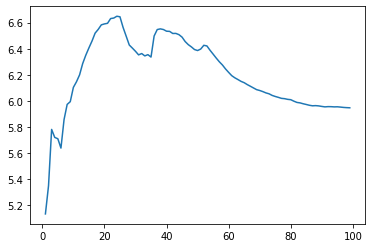

In [4]:
plt.plot(range(1,100),score_list)